In [ ]:
# ViT Training Script for CXR Classifier

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score

import timm  # ViT models

In [ ]:
LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
          'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
          'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']
NUM_CLASSES = len(LABELS)
BATCH_SIZE = 32
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),])

In [ ]:
class CheXpertDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = row[LABELS].astype(np.float32).values
        return image, torch.tensor(labels)

In [ ]:
# Load metadata
train_df = pd.read_csv("/content/drive/MyDrive/train/train_metadata_merged.csv")
val_df = pd.read_csv("/content/drive/MyDrive/val/val_metadata_merged.csv")

# Convert path_to_image to match actual image filenames
for df, root_dir in [(train_df, "/content/drive/MyDrive/train/images"),
                     (val_df, "/content/drive/MyDrive/val/images")]:
    df["filename"] = df["path_to_image"].str.replace("/", "_", regex=False)\
                                        .str.replace(".jpg", ".png", regex=False)
    df["image_path"] = root_dir + "/" + df["filename"]

# Clean labels
train_df[LABELS] = train_df[LABELS].fillna(0).replace(-1, 0)
val_df[LABELS] = val_df[LABELS].fillna(0).replace(-1, 0)

# Optionally filter missing images
train_df = train_df[train_df["image_path"].apply(os.path.exists)].copy()
val_df = val_df[val_df["image_path"].apply(os.path.exists)].copy()

# Dataset & loaders
train_dataset = CheXpertDataset(train_df, transform=transform)
val_dataset = CheXpertDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds.append(probs)
            targets.append(labels.cpu().numpy())

    preds = np.vstack(preds)
    targets = np.vstack(targets)
    binary_preds = (preds >= threshold).astype(int)

    aurocs, precisions, recalls, f1s = [], [], [], []

    for i in range(NUM_CLASSES):
        try:
            aurocs.append(roc_auc_score(targets[:, i], preds[:, i]))
            precisions.append(precision_score(targets[:, i], binary_preds[:, i], zero_division=0))
            recalls.append(recall_score(targets[:, i], binary_preds[:, i], zero_division=0))
            f1s.append(f1_score(targets[:, i], binary_preds[:, i], zero_division=0))
        except ValueError:
            aurocs.append(np.nan)
            precisions.append(np.nan)
            recalls.append(np.nan)
            f1s.append(np.nan)

    return {
        "AUROC": aurocs,
        "Precision": precisions,
        "Recall": recalls,
        "F1": f1s,
        "Mean AUROC": np.nanmean(aurocs),
        "Mean Precision": np.nanmean(precisions),
        "Mean Recall": np.nanmean(recalls),
        "Mean F1": np.nanmean(f1s),}

## pretrained ViT

In [ ]:
class ViTClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        self.vit = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTClassifier().to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    print(f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation + AUROC
    val_scores, mean_auc = evaluate(model, val_loader)
    print(f"  ➤ Loss: {avg_loss:.4f} | Mean AUROC: {mean_auc:.4f}")

Epoch 1/10


  ➤ Loss: 0.2971 | Mean AUROC: 0.7094
Epoch 2/10


  ➤ Loss: 0.2818 | Mean AUROC: 0.7258
Epoch 3/10


  ➤ Loss: 0.2730 | Mean AUROC: 0.7306
Epoch 4/10


  ➤ Loss: 0.2634 | Mean AUROC: 0.7293
Epoch 5/10


  ➤ Loss: 0.2504 | Mean AUROC: 0.7248
Epoch 6/10


  ➤ Loss: 0.2335 | Mean AUROC: 0.7213
Epoch 7/10


  ➤ Loss: 0.2122 | Mean AUROC: 0.7152
Epoch 8/10


  ➤ Loss: 0.1863 | Mean AUROC: 0.7012
Epoch 9/10


  ➤ Loss: 0.1591 | Mean AUROC: 0.7060
Epoch 10/10


  ➤ Loss: 0.1300 | Mean AUROC: 0.6970


In [ ]:
print("\nFinal Evaluation on Validation Set:")
final_metrics = evaluate(model, val_loader)

print(f"\nMean AUROC:     {final_metrics['Mean AUROC']:.4f}")
print(f"Mean Precision: {final_metrics['Mean Precision']:.4f}")
print(f"Mean Recall:    {final_metrics['Mean Recall']:.4f}")
print(f"Mean F1 Score:  {final_metrics['Mean F1']:.4f}\n")

print("Per-Label Metrics:")
for i, label in enumerate(LABELS):
    print(f"{label:25s} | AUROC: {final_metrics['AUROC'][i]:.3f} | "
          f"Prec: {final_metrics['Precision'][i]:.3f} | Rec: {final_metrics['Recall'][i]:.3f} | "
          f"F1: {final_metrics['F1'][i]:.3f}")


Final Evaluation on Validation Set:



Mean AUROC:     0.6970
Mean Precision: 0.3659
Mean Recall:    0.2044
Mean F1 Score:  0.2398

Per-Label Metrics:
Atelectasis               | AUROC: 0.671 | Prec: 0.273 | Rec: 0.115 | F1: 0.162
Cardiomegaly              | AUROC: 0.790 | Prec: 0.492 | Rec: 0.333 | F1: 0.397
Consolidation             | AUROC: 0.676 | Prec: 0.462 | Rec: 0.026 | F1: 0.048
Edema                     | AUROC: 0.776 | Prec: 0.367 | Rec: 0.204 | F1: 0.262
Enlarged Cardiomediastinum | AUROC: 0.572 | Prec: 0.188 | Rec: 0.014 | F1: 0.027
Fracture                  | AUROC: 0.584 | Prec: 0.000 | Rec: 0.000 | F1: 0.000
Lung Lesion               | AUROC: 0.638 | Prec: 0.233 | Rec: 0.089 | F1: 0.129
Lung Opacity              | AUROC: 0.670 | Prec: 0.498 | Rec: 0.500 | F1: 0.499
No Finding                | AUROC: 0.760 | Prec: 0.421 | Rec: 0.375 | F1: 0.396
Pleural Effusion          | AUROC: 0.857 | Prec: 0.768 | Rec: 0.516 | F1: 0.618
Pleural Other             | AUROC: 0.687 | Prec: 0.184 | Rec: 0.047 | F1: 0.075
Pneumo

In [ ]:
torch.save(model, "/content/drive/MyDrive/vit_full_model_pretrained.pt")
print("Full model saved to vit_full_model.pt")

Full model saved to vit_full_model.pt


## Untrained ViT

In [ ]:
class ViTClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=NUM_CLASSES, pretrained=False):
        super().__init__()
        self.vit = timm.create_model(model_name,
                                     pretrained=False,
                                     drop_rate=0.1,
                                     attn_drop_rate=0.1)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTClassifier().to(DEVICE)

In [ ]:
# penalize missing rare positives more heavily

# Compute label frequencies
label_freq = train_df[LABELS].mean()

# Compute pos_weight = (1 - p) / p for each label
pos_weight = (1 - label_freq) / label_freq

In [ ]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight.values, dtype=torch.float32).to(DEVICE))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

In [ ]:
EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    print(f"Epoch {epoch+1}/{EPOCHS}")
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation + AUROC
    val_metrics = evaluate(model, val_loader)
    scheduler.step(val_metrics['Mean AUROC'])
    print(f"  ➤ Loss: {avg_loss:.4f} | Mean AUROC: {val_metrics['Mean AUROC']:.4f}")

Epoch 1/30


  ➤ Loss: 1.2168 | Mean AUROC: 0.5899
Epoch 2/30


  ➤ Loss: 1.1986 | Mean AUROC: 0.5982
Epoch 3/30


  ➤ Loss: 1.1842 | Mean AUROC: 0.6120
Epoch 4/30


  ➤ Loss: 1.1756 | Mean AUROC: 0.6211
Epoch 5/30


  ➤ Loss: 1.1660 | Mean AUROC: 0.6221
Epoch 6/30


  ➤ Loss: 1.1562 | Mean AUROC: 0.6366
Epoch 7/30


  ➤ Loss: 1.1460 | Mean AUROC: 0.6352
Epoch 8/30


  ➤ Loss: 1.1368 | Mean AUROC: 0.6401
Epoch 9/30


  ➤ Loss: 1.1289 | Mean AUROC: 0.6438
Epoch 10/30


  ➤ Loss: 1.1190 | Mean AUROC: 0.6429
Epoch 11/30


  ➤ Loss: 1.1076 | Mean AUROC: 0.6457
Epoch 12/30


  ➤ Loss: 1.0966 | Mean AUROC: 0.6450
Epoch 13/30


  ➤ Loss: 1.0803 | Mean AUROC: 0.6490
Epoch 14/30


  ➤ Loss: 1.0627 | Mean AUROC: 0.6492
Epoch 15/30


  ➤ Loss: 1.0404 | Mean AUROC: 0.6493
Epoch 16/30


  ➤ Loss: 1.0109 | Mean AUROC: 0.6465
Epoch 17/30


  ➤ Loss: 0.9742 | Mean AUROC: 0.6430
Epoch 18/30


  ➤ Loss: 0.9308 | Mean AUROC: 0.6419
Epoch 19/30


  ➤ Loss: 0.8715 | Mean AUROC: 0.6370
Epoch 20/30


  ➤ Loss: 0.8125 | Mean AUROC: 0.6361
Epoch 21/30


  ➤ Loss: 0.7490 | Mean AUROC: 0.6314
Epoch 22/30


  ➤ Loss: 0.6724 | Mean AUROC: 0.6283
Epoch 23/30


  ➤ Loss: 0.6113 | Mean AUROC: 0.6278
Epoch 24/30


  ➤ Loss: 0.5407 | Mean AUROC: 0.6238
Epoch 25/30


  ➤ Loss: 0.4831 | Mean AUROC: 0.6157
Epoch 26/30


  ➤ Loss: 0.4373 | Mean AUROC: 0.6178
Epoch 27/30


  ➤ Loss: 0.4006 | Mean AUROC: 0.6149
Epoch 28/30


  ➤ Loss: 0.3606 | Mean AUROC: 0.6095
Epoch 29/30


  ➤ Loss: 0.3301 | Mean AUROC: 0.6075
Epoch 30/30


  ➤ Loss: 0.2958 | Mean AUROC: 0.6052


In [ ]:
print("\nFinal Evaluation on Validation Set:")
final_metrics = evaluate(model, val_loader)

print(f"\nMean AUROC:     {final_metrics['Mean AUROC']:.4f}")
print(f"Mean Precision: {final_metrics['Mean Precision']:.4f}")
print(f"Mean Recall:    {final_metrics['Mean Recall']:.4f}")
print(f"Mean F1 Score:  {final_metrics['Mean F1']:.4f}\n")

print("Per-Label Metrics:")
for i, label in enumerate(LABELS):
    print(f"{label:25s} | AUROC: {final_metrics['AUROC'][i]:.3f} | "
          f"Prec: {final_metrics['Precision'][i]:.3f} | Rec: {final_metrics['Recall'][i]:.3f} | "
          f"F1: {final_metrics['F1'][i]:.3f}")


Final Evaluation on Validation Set:



Mean AUROC:     0.6052
Mean Precision: 0.1882
Mean Recall:    0.2884
Mean F1 Score:  0.2239

Per-Label Metrics:
Atelectasis               | AUROC: 0.616 | Prec: 0.175 | Rec: 0.321 | F1: 0.227
Cardiomegaly              | AUROC: 0.713 | Prec: 0.283 | Rec: 0.271 | F1: 0.277
Consolidation             | AUROC: 0.573 | Prec: 0.078 | Rec: 0.119 | F1: 0.094
Edema                     | AUROC: 0.722 | Prec: 0.194 | Rec: 0.256 | F1: 0.221
Enlarged Cardiomediastinum | AUROC: 0.484 | Prec: 0.061 | Rec: 0.081 | F1: 0.070
Fracture                  | AUROC: 0.504 | Prec: 0.051 | Rec: 0.089 | F1: 0.065
Lung Lesion               | AUROC: 0.527 | Prec: 0.074 | Rec: 0.213 | F1: 0.110
Lung Opacity              | AUROC: 0.594 | Prec: 0.393 | Rec: 0.635 | F1: 0.485
No Finding                | AUROC: 0.697 | Prec: 0.320 | Rec: 0.438 | F1: 0.370
Pleural Effusion          | AUROC: 0.741 | Prec: 0.470 | Rec: 0.573 | F1: 0.516
Pleural Other             | AUROC: 0.556 | Prec: 0.049 | Rec: 0.128 | F1: 0.071
Pneumo

In [ ]:
torch.save(model, "/content/drive/MyDrive/vit_full_model_5.26.pt")
print("Full model saved to vit_full_model_5.26.pt")

Full model saved to vit_full_model_5.26.pt


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/vit_weights_only_5.26.pt")

In [ ]:

from torchvision import transforms

import torch
import torch.nn as nn
import timm  # Make sure timm is installed

class ViTClassifier(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=NUM_CLASSES, pretrained=False):
        super().__init__()
        self.vit = timm.create_model(model_name,
                                     pretrained=pretrained,
                                     drop_rate=0.1,
                                     attn_drop_rate=0.1)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Re-initialize model architecture
model = ViTClassifier()
model.load_state_dict(torch.load("/content/drive/MyDrive/vit_weights_only_5.26.pt", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval().to(DEVICE)

ViTClassifier(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')


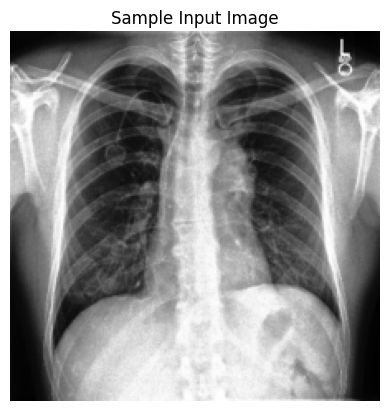

Top Predictions:
Support Devices     0.793036
Pneumothorax        0.777953
No Finding          0.770491
Pleural Effusion    0.307409
Lung Opacity        0.256686
dtype: float32


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
# === Transform for input image ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),  # Adjust if needed
])

# === Load and process image ===
img_path = "/content/drive/MyDrive/val/images/train_patient00005_study1_view1_frontal.png"  # Replace with your path
image = Image.open(img_path).convert("RGB")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = transform(image).unsqueeze(0).to(device)

# === Inference ===
with torch.no_grad():
    output = model(input_tensor)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()

# === Visualize ===
plt.imshow(image)
plt.axis('off')
plt.title("Sample Input Image")
plt.show()

# === Display predicted labels ===
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
          'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
          'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']
preds = pd.Series(probs, index=CLASS_NAMES).sort_values(ascending=False)
print("Top Predictions:")
print(preds.head(5))